### Pole-Cart Model Estimation
The pole cart model depends on various parameters. We use an ensamble of models to estimate the best model. The parameters corresponds to
- pole length
- pole mass
- cart mass
- cart friction
- pole friction

### Generate Data
First generate the data by running the unit test. The point mass is subject to a sinusoidal force. 

`catkin run_tests mppi_est --no-deps`

In [15]:
# Extract first system evolutions from logs
t = []   # time
xc = []  # cart position 
xp = []  # pole position
vc = []  # cart velocity
vp = []  # pole velocity
F = []  # force

with open("../logs/pole_cart/system.txt") as stream:
    for line in stream:
        values = line.split()
        t.append(float(values[0]))
        xc.append(float(values[1]))
        xp.append(float(values[2]))
        vc.append(float(values[3]))
        vp.append(float(values[4]))
        F.append(float(values[5]))

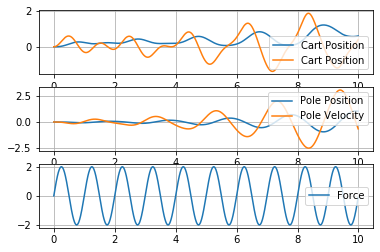

In [26]:
import matplotlib.pyplot as plt

%matplotlib inline
fig, ax = plt.subplots(3, 1)
ax[0].plot(t, xc, label="Cart Position")
ax[0].plot(t, vc, label="Cart Position")
ax[0].legend()
ax[0].grid()

ax[1].plot(t, xp, label="Pole Position")
ax[1].plot(t, vp, label="Pole Velocity")
ax[1].legend()
ax[1].grid()

ax[2].plot(t, F, label="Force")
ax[2].legend()
ax[2].grid()


### Deviations
Lets plot the deviations with respect to the true model.

In [27]:
deviations = []

with open("../logs/pole_cart/deviations.txt") as stream:
    for line in stream:
        values = line.split()
        deviations.append([float(value) for value in values])

%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

def f(iteration):
    d = deviations[iteration]
    plt.figure(2)
    plt.bar(list(range(0, len(d))), d)
    plt.show()
    
interactive_plot = interactive(f, iteration=(0, len(deviations)-1))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

### Posterior
We plot now the posterior as the system evolves with time.

In [28]:
params = []
params_idx = []
posteriors = []

with open("../logs/pole_cart/params.txt") as stream:
    for line in stream:
        values = line.split()
        params.append([float(value) for value in values])
params_idx = list(range(0, len(params)))

with open("../logs/pole_cart/posterior.txt") as stream:
    for line in stream:
        values = line.split()
        posterior = [float(value) for value in values]
        posteriors.append(posterior)

In [29]:
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

def f(iteration):
    p = posteriors[iteration]
    plt.figure(2)
    plt.bar(params_idx, p)
    plt.show()
    
    map_idx = np.argmax(p)
    print("Cumulative: {}".format(sum(p)))
    print("MAP : {}, p={}".format(params[map_idx], p[map_idx]))

interactive_plot = interactive(f, iteration=(0, len(posteriors)-1))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

### Heatmap

In [59]:
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

pole_params = [params[0][2]]
friction_params = [params[0][3]]

# the inner grid loops over pole lengths
for p in params[1:]:
    if p[2] == pole_params[0]:
        break
    pole_params.append(p[2])

pole_params_size = int(len(pole_params))
friction_params_size = int(len(params)/pole_params_size)

likelihood_matrix = np.empty([pole_params_size, friction_params_size])


def f(iteration):
    p = posteriors[iteration]
    idx = 0
    # unflatten likelihood matrix
    for i in range(friction_params_size):
        for j in range(pole_params_size):
            likelihood_matrix[j, i] = p[idx]
            idx += 1
    plt.figure(2)
    plt.imshow(likelihood_matrix, cmap='RdBu', vmin=0, vmax=max(p),
               extent=[min(friction_params),max(friction_params),min(pole_params),max(pole_params)],
               interpolation='none', origin='lower', aspect='auto')
    plt.colorbar()
    plt.show()
    
    map_idx = np.argmax(p)
    print("Cumulative: {}".format(sum(p)))
    print("MAP : {}, p={}".format(params[map_idx], p[map_idx]))

interactive_plot = interactive(f, iteration=(0, len(posteriors)-1))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot